In [1]:
import os
import sys
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from data_handle import(
    ForexDataClean,
    ForexDataLoad
)

from features import ForexFeauturesExtractor

from plots import ForexPlotter
from models import TimeSeriesAutoencoder
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

data = ForexDataLoad(file_path = '../data/usdjpy.csv').data

cleaner = ForexDataClean(data = data)
data = cleaner.fast_cleaner()

features = ForexFeauturesExtractor(
    data = data,
    momentum_parameters = {
        'rsi_periods' : [4, 6, 8, 10, 12, 14],
        'stoch_fk_sk_sd_periods' : [[4, 1, 1], [6, 1, 1], [8, 2, 2], [10, 2, 2], [12, 3, 3], [14, 3, 3]],
        'williams_periods' :  [4, 6, 8, 10, 12, 14],
        'cci_periods' :  [4, 6, 8, 10, 12, 14],
        'momentum_periods' : [4, 6, 8, 10, 12, 14]
    },
)

indicators_data, signals_data, extreme_data = features.extract_all_features()


FOREX DATA LOADER
 Available Fuctions 
1 load_csv 
2 load_from_database
Data loaded successfully!
Shape: (41476, 5)

FOREX DATA CLEANER
 Available Fuctions 
1 remove_duplicates 
2 handle_missing_values 
3 validate_ohlc_integrity 
4 handle_outliers 
5 fast_cleaner
Keep = first and subset = None
Removed 0 duplicate entries
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent
No missing values found
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent


In [2]:
trend_dir = signals_data['trend_strength']

In [3]:
trend_dir.shape

(41276, 23)

In [4]:
autoencoder = TimeSeriesAutoencoder(
    input_dim = trend_dir.shape[1] - 1,  
    encoding_dim = 2,
    learning_rate = 0.001
)

In [5]:
train_data, test_data = autoencoder.prepare_data(
    trend_dir, 
    target_column = 'close',
    test_size = 0.2
)

Training samples: 33020
Test samples: 8256


In [6]:
history = autoencoder.train(
    epochs = 25, 
    batch_size = 12, 
    verbose = 1
)

Epoch 1/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.4986 - mae: 0.4263 - val_loss: 0.5771 - val_mae: 0.4074
Epoch 2/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3623 - mae: 0.3450 - val_loss: 0.4735 - val_mae: 0.3618
Epoch 3/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3031 - mae: 0.3067 - val_loss: 0.4383 - val_mae: 0.3252
Epoch 4/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2775 - mae: 0.2881 - val_loss: 0.3938 - val_mae: 0.3079
Epoch 5/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2633 - mae: 0.2781 - val_loss: 0.3762 - val_mae: 0.3060
Epoch 6/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2519 - mae: 0.2704 - val_loss: 0.3627 - val_mae: 0.2936
Epoch 7/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2440 - mae: 0.2659 - val_loss: 0.3614 - val_mae: 0.2959
Epoch 8/25
2752/2752 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2396 - mae: 0.2617 - val_loss: 0.3452 - val_mae: 0.2839
Epoch 9/25
2752/2752 ━━━━━━━━━━━━━━━━━━━

In [7]:
labels_data_with_latent = autoencoder.add_latent_features(trend_dir)

In [8]:
metrics = autoencoder.evaluate()
print("\nModel Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Model Metrics:
final_training_loss: 0.2390
final_validation_loss: 0.3027
training_reconstruction_error: 0.2170
test_reconstruction_error: 0.3027
generalization_gap: 0.0857


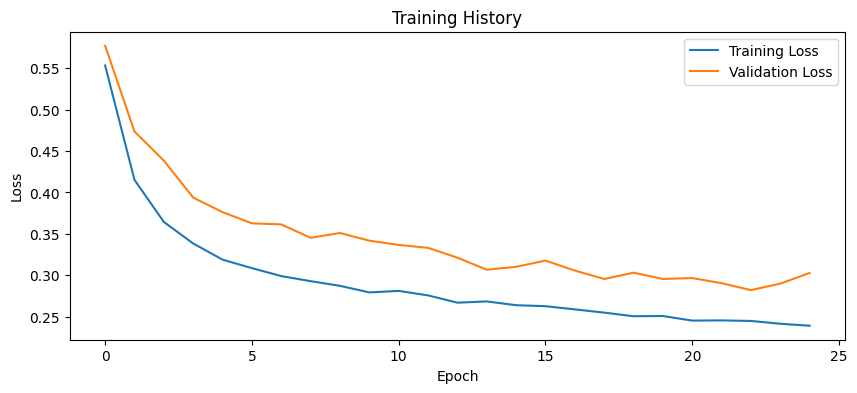

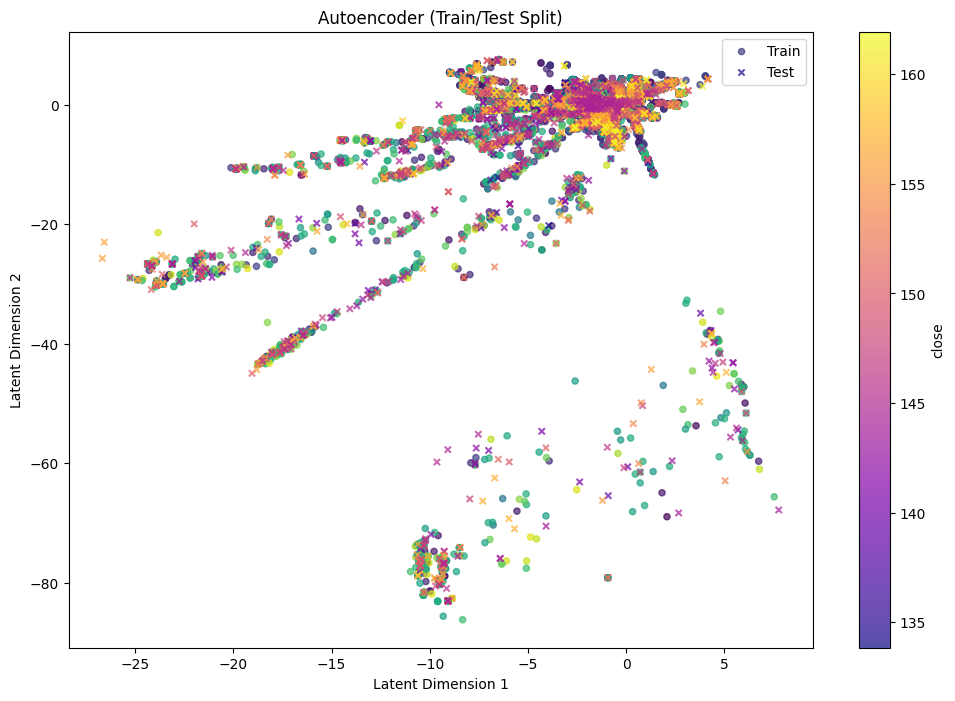

In [9]:
autoencoder.plot_training_history()
autoencoder.plot_latent_space(
    labels_data_with_latent, 
    color_by = 'close'
)

In [10]:
df = labels_data_with_latent[[
    'close', 
    'latent_dim_1', 
    'latent_dim_2'
]]

In [11]:
print(df.tail())

                       close  latent_dim_1  latent_dim_2
datetime                                                
2024-09-02 14:00:00  146.985     -6.301015    -12.206338
2024-09-02 15:00:00  146.979    -12.144024    -22.767136
2024-09-02 16:00:00  146.961     -5.388695     -8.116452
2024-09-02 17:00:00  146.959     -5.388695     -8.116452
2024-09-02 18:00:00  146.923      2.560422     -0.092691


In [12]:
close_prices = labels_data_with_latent['close'].values

min_indices = argrelextrema(
    close_prices, 
    np.less, 
    order = 5
)[0]

max_indices = argrelextrema(
    close_prices, 
    np.greater, 
    order = 5
)[0]

labels_data_with_latent['is_extrema'] = 0
labels_data_with_latent.loc[labels_data_with_latent.index[min_indices], 'is_extrema'] = 1 
labels_data_with_latent.loc[labels_data_with_latent.index[max_indices], 'is_extrema'] = 2  

normal_points = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 0]
minima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 1]
maxima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 2]

for extrema_type, data, label in [
    (0, normal_points, 'Normal Points'),
    (1, minima_latent, 'Minima (Buy)'),
    (2, maxima_latent, 'Maxima (Sell)')
]:
    
    print(f"\n {label} (n={len(data)}):")
    print(f"Latent Dim 1: {data['latent_dim_1'].mean():.4f} ± {data['latent_dim_1'].std():.4f}")
    print(f"Latent Dim 2: {data['latent_dim_2'].mean():.4f} ± {data['latent_dim_2'].std():.4f}")


 Normal Points (n=36130):
Latent Dim 1: -1.9473 ± 3.6277
Latent Dim 2: -1.5673 ± 8.1268

 Minima (Buy) (n=2540):
Latent Dim 1: -2.5044 ± 3.7447
Latent Dim 2: -3.3959 ± 10.5307

 Maxima (Sell) (n=2606):
Latent Dim 1: -1.5481 ± 3.7873
Latent Dim 2: -1.0353 ± 9.6033


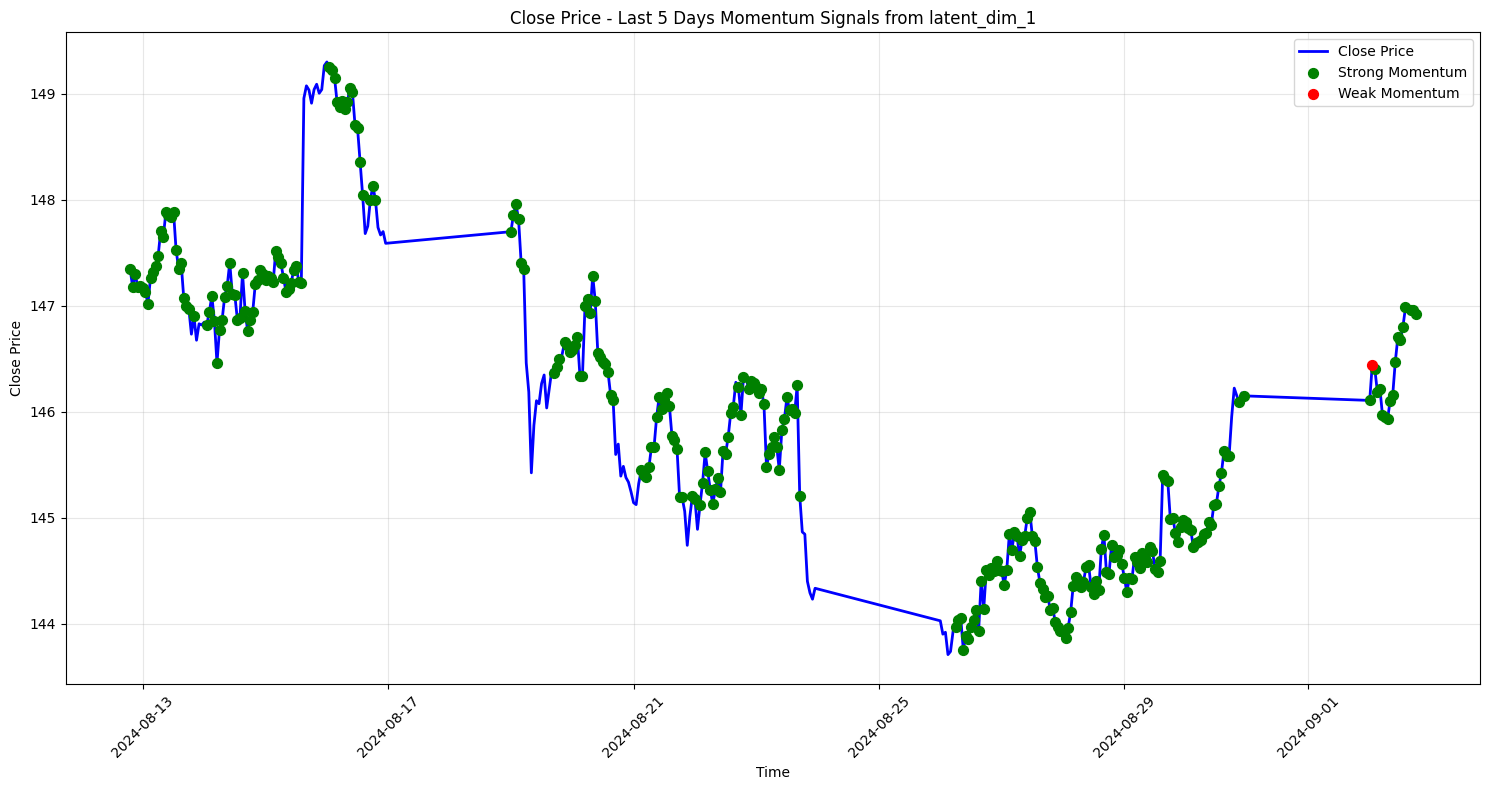

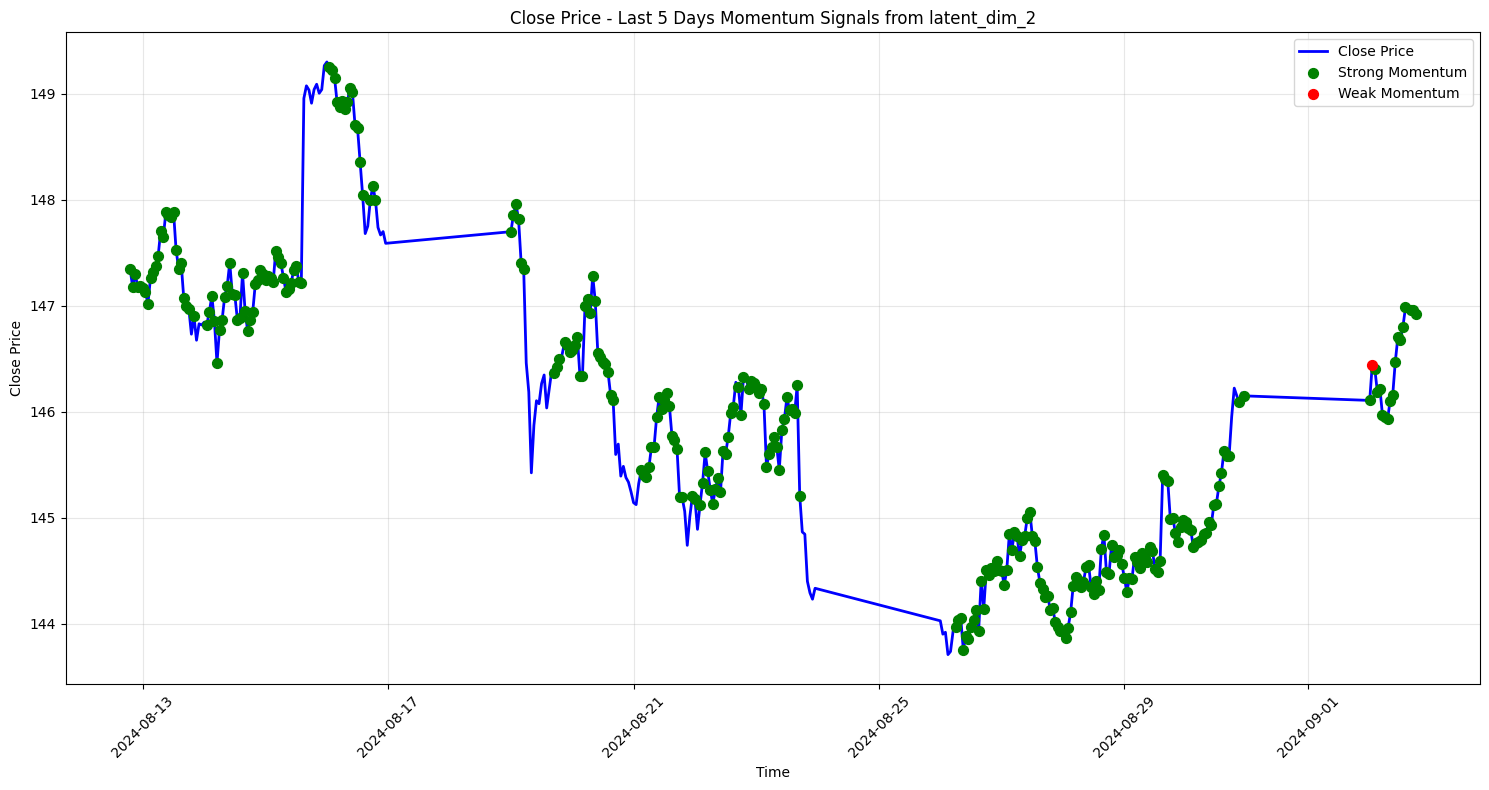

Strong Momentum:293
Weak Momentum:1


In [15]:
def auto_signal(
    latent_1, 
    latent_2
):
    buy_zone_l1 = (
        minima_latent['latent_dim_1'].mean() - 1.5 * minima_latent['latent_dim_1'].std(),
        minima_latent['latent_dim_1'].mean() + 1.5 * minima_latent['latent_dim_1'].std()
    )

    buy_zone_l2 = (
        minima_latent['latent_dim_2'].mean() - 1.5 * minima_latent['latent_dim_2'].std(),
        minima_latent['latent_dim_2'].mean() + 1.5 * minima_latent['latent_dim_2'].std()
    )

    sell_zone_l1 = (
        maxima_latent['latent_dim_1'].mean() - 1.5 * maxima_latent['latent_dim_1'].std(),
        maxima_latent['latent_dim_1'].mean() + 1.5 * maxima_latent['latent_dim_1'].std()
    )

    sell_zone_l2 = (
        maxima_latent['latent_dim_2'].mean() - 1.5 * maxima_latent['latent_dim_2'].std(),
        maxima_latent['latent_dim_2'].mean() + 1.5 * maxima_latent['latent_dim_2'].std()
    )
    
    if (sell_zone_l1[0] <= latent_1 <= sell_zone_l1[1] and sell_zone_l2[0] <= latent_2 <= sell_zone_l2[1]):
        return 'sell'
    elif (buy_zone_l1[0] <= latent_1 <= buy_zone_l1[1] and buy_zone_l2[0] <= latent_2 <= buy_zone_l2[1]):
        return 'buy'
    else:
        return 'hold'

last_5_days = labels_data_with_latent.tail(24 * 15)
last_5_days['signal'] = last_5_days.apply(
    lambda row: auto_signal(row['latent_dim_1'], row['latent_dim_2']), axis=1
)

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index, 
    last_5_days['close'], 
    linewidth=2, 
    label='Close Price',
    color='blue'
)

buy_signals_1 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_1 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_1.index, 
    buy_signals_1['close'], 
    color='green', 
    marker='o', 
    s=50, 
    label='Strong Momentum',
    zorder=5
)

plt.scatter(
    sell_signals_1.index,
    sell_signals_1['close'], 
    color='red',
    marker='o', 
    s=50,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Days Momentum Signals from latent_dim_1')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index,
    last_5_days['close'],
    linewidth=2,
    label='Close Price',
    color='blue'
)

buy_signals_2 = last_5_days[last_5_days['signal'] == 'sell']
sell_signals_2 = last_5_days[last_5_days['signal'] == 'buy']

plt.scatter(
    buy_signals_2.index,        
    buy_signals_2['close'], 
    color='green',
    marker='o', 
    s=50, 
    label='Strong Momentum', 
    zorder=5
)

plt.scatter(
    sell_signals_2.index, 
    sell_signals_2['close'], 
    color='red',
    marker='o',
    s=50,
    label='Weak Momentum',
    zorder=5
)

plt.title('Close Price - Last 5 Days Momentum Signals from latent_dim_2')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(f"Strong Momentum:{len(buy_signals_1)}")
print(f"Weak Momentum:{len(sell_signals_1)}")